# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets

# Dataset

In [2]:
dataset = datasets.ML100k(neg_pair_weight=30)
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set()

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.062832,0.92541,9.183483,0.063362,0.092706,0.120492,0.030536,0.126467,0.925284,9.182233,...,0.181495,0.241795,0.092766,0.522641,0.872119,8.656916,0.52219,0.555046,0.947506,0.513558


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.239628,0.741081,4.043593,0.019231,0.252707,0.399248,0.024554,0.487369,0.668806,3.584468,...,0.463935,0.803657,0.06807,0.900484,0.74025,5.732233,0.424922,0.79644,1.522222,0.488876


## CML+MP

In [9]:
n_item_sample = 600
n_user_sample = 600
bias_li = np.arange(0.0, 1.1, 0.1).tolist()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.MutualProximity(model, gamma, n_item_sample, n_user_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

search_range=10


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.182739,0.772737,4.556509,0.029413,0.219588,0.319726,0.025182,0.456224,0.701047,4.182,...,0.45328,0.778237,0.080833,0.542094,0.865059,8.329221,0.50688,0.56202,0.978313,0.514497


search_range=15


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.131479,0.811207,5.182282,0.039759,0.174375,0.237729,0.019852,0.415343,0.69339,4.053237,...,0.431413,0.707323,0.077745,0.653568,0.838186,7.866402,0.48833,0.656171,1.174888,0.544751


search_range=20


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.101506,0.838074,5.675835,0.0468,0.142117,0.186261,0.015563,0.332404,0.72955,4.626953,...,0.376232,0.579766,0.072879,0.73137,0.815107,7.446026,0.47305,0.712216,1.306961,0.547356


search_range=25


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.083721,0.856254,6.039636,0.051369,0.121944,0.155137,0.012929,0.275798,0.758914,5.094842,...,0.330413,0.488049,0.066085,0.784583,0.796192,7.075935,0.46094,0.745632,1.393137,0.539838


search_range=30


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,...,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.071982,0.869316,6.321591,0.054585,0.111134,0.134247,0.011112,0.236269,0.781737,5.467513,...,0.294593,0.422305,0.060054,0.821752,0.780801,6.750523,0.451236,0.766081,1.449439,0.529333


In [ ]:
re_recall = []
re_unpop1 = []
re_unpop2 = []
re_unpop3 = []
for re in re_mpcmp_li:
    re_recall.append(re.iloc[-1, 7])
    re_unpop1.append(re.iloc[-1, 8])
    re_unpop2.append(re.iloc[-1, 9])
    re_unpop3.append(re.iloc[-1, 10])

## Recall vs Unpopularity1

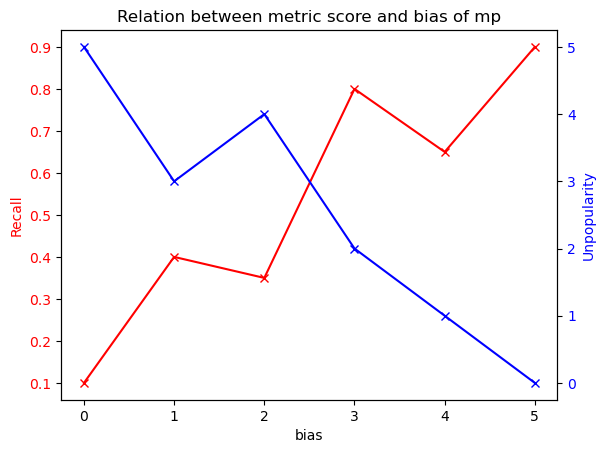

In [2]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop1, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
plt.axhline(y=re_no_training.iloc[-1, 7], color='red', linestyle='--')
plt.axhline(y=re_no_training.iloc[-1, 8], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity2

In [ ]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
plt.axhline(y=re_no_training.iloc[-1, 7], color='red', linestyle='--')
plt.axhline(y=re_no_training.iloc[-1, 9], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity3

In [ ]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
plt.axhline(y=re_no_training.iloc[-1, 7], color='red', linestyle='--')
plt.axhline(y=re_no_training.iloc[-1, 10], color='blue', linestyle='--')

# グラフの表示
plt.show()